In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
#from imblearn.over_sampling import *
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import shap

In [4]:
datos = pd.read_csv("../2_DataPreparation/DataPrepared_120.csv")

In [5]:
datos.head()

,id,Window,glucose_value,difference_glucose_normal,is_diabetes_diabetes,is_diabetes_normal,is_diabetes_prediabetes,hgb_value,hgb_class_High,hgb_class_Low,...,WindowCombinationDrugs_metoprolol-valsartan-100-640,WindowCombinationDrugs_metoprolol-metoprolol-metoprolol-100-50-100,WindowCombinationDrugs_metoprolol-metoprolol-valsartan-50-100-640,WindowCombinationDrugs_pitavastatin-2,Drug_DailyDosage_DurationDose_pitavastatin-2-3,WindowCombinationDrugs_atorvastatin-atorvastatin-metformin-20-20-1000,WindowCombinationDrugs_atorvastatin-losartan-losartan-losartan-10-100-100-100,WindowCombinationDrugs_atorvastatin-atorvastatin-atorvastatin-losartan-losartan-losartan-losartan-10-10-10-100-100-100-100,WindowCombinationDrugs_atorvastatin-losartan-10-100,Stage_Progress
0,0,1080,5.780000,1.920000,0,1,0,12.672149,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,120,6.351074,1.348926,0,1,0,13.496116,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,1200,5.780000,1.920000,0,1,0,13.645556,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,240,7.200000,0.500000,0,1,0,13.390000,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,360,7.082231,0.617769,0,1,0,13.049091,0,1,...,0,0,0,0,0,0,0,0,0,1


In [6]:
datosResponse = datos["Stage_Progress"].to_numpy()

In [7]:
#datos = datos[["CentroEntrega","RegionEntrega","CantidadDespuesCritica","VolumenHLOrdenado","SubCanal"]]
datos = datos.loc[:, datos.columns != 'Stage_Progress']
datos = datos.loc[:, datos.columns != 'id']
datos = datos.loc[:, datos.columns != 'Window']
datos = datos.loc[:, datos.columns != 'start_day']
datos = datos.loc[:, datos.columns != 'end_day']

In [8]:
for i in datos.columns:
    print(i)

glucose_value
difference_glucose_normal
is_diabetes_diabetes
is_diabetes_normal
is_diabetes_prediabetes
hgb_value
hgb_class_High
hgb_class_Low
hgb_class_Normal
sbp_value
dbp_value
sbp_diff_normal
dbp_diff_normal
bp_class_Elevated
bp_class_Hypertension1
bp_class_Hypertension2
bp_class_HypertensiveCrisis
bp_class_Normal
bp_is_controlled_0
bp_is_controlled_1
ldl_value
diff_Ldl_normal
LDL_class_BorderlineHigh
LDL_class_High
LDL_class_NearNormal
LDL_class_Normal
LDL_class_VeryHigh
creatinine_value
GFR
gfr_evolution
gfr_class_G1
gfr_class_G2
gfr_class_G3a
gfr_class_G3b
gfr_class_G4
gfr_class_G5
age
race_Asian
race_Black
race_Hispanic
race_Unknown
race_White
gender_Female
gender_Male
durationDose
WindowNumberDrugs
TotalDailyDosage
drug_atorvastatin
drug_losartan
drug_metformin
WindowCombinationDrugs_atorvastatin-atorvastatin-losartan-metformin-10-10-100-1000
Drug_DailyDosage_DurationDose_atorvastatin-10-90
Drug_DailyDosage_DurationDose_losartan-100-270
Drug_DailyDosage_DurationDose_metformin-

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(datos, datosResponse)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
scaler = StandardScaler()


X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)


X_valid = pd.DataFrame(scaler.transform(X_valid.values), columns=X_valid.columns, index=X_valid.index)



X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)



In [10]:
#xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", n_estimators=100,
#                             max_depth=18, booster = "gbtree", reg_lambda = 3, gamma = 0, eta = 0.3, tree_method = "exact",min_child_weight=1,
#                                     grow_policy = "lossguide", scale_pos_weight = 5)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="logloss", n_estimators=100,
                             max_depth=12, booster = "gbtree", reg_lambda = 3, gamma = 1, eta = 0.3, tree_method = "exact",min_child_weight=1,
                                     grow_policy = "lossguide", scale_pos_weight = 2)

In [11]:
#binary:logistic multi:softmax
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_test,y_test)], verbose=True)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-logloss:0.54003	validation_1-logloss:0.57534
[1]	validation_0-logloss:0.44450	validation_1-logloss:0.51692
[2]	validation_0-logloss:0.36741	validation_1-logloss:0.45878
[3]	validation_0-logloss:0.31060	validation_1-logloss:0.41941
[4]	validation_0-logloss:0.26465	validation_1-logloss:0.38304
[5]	validation_0-logloss:0.23109	validation_1-logloss:0.36131
[6]	validation_0-logloss:0.20450	validation_1-logloss:0.34231
[7]	validation_0-logloss:0.18081	validation_1-logloss:0.32046
[8]	validation_0-logloss:0.16142	validation_1-logloss:0.30736
[9]	validation_0-logloss:0.14830	validation_1-logloss:0.30160
[10]	validation_0-logloss:0.13300	validation_1-logloss:0.28537
[11]	validation_0-logloss:0.12285	validation_1-logloss:0.27809
[12]	validation_0-logloss:0.11429	validation_1-logloss:0.26826
[13]	validation_0-logloss:0.10485	validation_1-logloss:0.25733
[14]	validation_0-logloss:0.09872	validation_1-logloss:0.25361
[15]	validation_0-logloss:0.09252	validation_1-logloss:0.24863
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3,
              eval_metric='logloss', gamma=1, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=3,
              scale_pos_weight=2, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [12]:
from sklearn.metrics import classification_report

y_predOrig = xgb_model.predict(X_test)

print(classification_report(y_test, y_predOrig))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       485
           1       0.88      0.89      0.88       261

    accuracy                           0.92       746
   macro avg       0.91      0.91      0.91       746
weighted avg       0.92      0.92      0.92       746



In [13]:
from sklearn.metrics import classification_report

y_predOrig = xgb_model.predict(X_valid)


print(classification_report(y_valid, y_predOrig))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       365
           1       0.91      0.89      0.90       195

    accuracy                           0.93       560
   macro avg       0.93      0.92      0.92       560
weighted avg       0.93      0.93      0.93       560



In [14]:
##Cross Validation
kFold = KFold(n_splits = 10)
res = cross_val_score(xgb_model, X_test, y_test, cv=kFold)
print("The Accuracy is: %.2f%% (%.2f%%)" % (res.mean()*100, res.std()*100))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

The Accuracy is: 83.92% (3.96%)


In [15]:
kFold = KFold(n_splits = 10)
res = cross_val_score(xgb_model, X_train_full, y_train_full, cv=kFold)
print("The Accuracy is: %.2f%% (%.2f%%)" % (res.mean()*100, res.std()*100))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

The Accuracy is: 94.23% (1.46%)


In [16]:
results = xgb_model.evals_result()

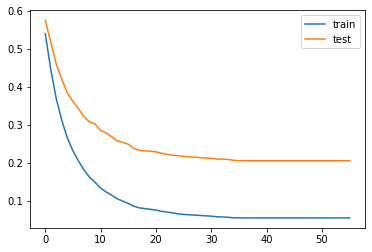

In [17]:
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')

pyplot.legend()

pyplot.show()

In [18]:
#####HyperOpt for searching the best hyperparameters
space={'max_depth': hp.quniform("max_depth", 8, 25, 1),'gamma': hp.uniform ('gamma', 0,9),
       'reg_alpha' : hp.quniform('reg_alpha', 0,5,1),'reg_lambda' : hp.uniform('reg_lambda', 0,5),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.9,1),'min_child_weight' : hp.quniform('min_child_weight', 0, 25, 1),
       'n_estimators': 150,'seed': 0}

In [19]:
kF = KFold(n_splits = 3)

In [20]:
def objective(space):
    clf=xgb.XGBClassifier(objective="binary:logistic",n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],reg_alpha = int(space['reg_alpha']),
                         scale_pos_weight = 6, seed = space['seed'], reg_lambda = int(space['reg_lambda']), colsample_bytree = (space['colsample_bytree']), min_child_weight = space['min_child_weight'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    clf.fit(X_train, y_train,eval_set=evaluation, eval_metric="auc",early_stopping_rounds=10,verbose=False)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
            
    

In [304]:
def objective(space, cv = kF):
    clf=xgb.XGBClassifier(objective="binary:logistic",n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],reg_alpha = int(space['reg_alpha']),
                         scale_pos_weight = 6, grow_policy = "depthwise", seed = space['seed'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    clf.fit(X_train, y_train,eval_set=evaluation, eval_metric="auc",early_stopping_rounds=10,verbose=False)
    #pred = clf.predict(X_test)
    #accuracy = accuracy_score(y_test, pred)
    score = -cross_val_score(clf, X_test, y_test, cv=cv, scoring="accuracy", n_jobs=-1).mean()
    print ("SCORE:", score)
    return {'loss': score, 'status': STATUS_OK }
            
    

In [21]:
trials = Trials()

best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest,max_evals = 100,trials = trials)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.7627345844504021                                                                                                     
  1%|▍                                              | 1/100 [00:01<01:43,  1.04s/trial, best loss: -0.7627345844504021]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8445040214477212                                                                                                     
  2%|▉                                              | 2/100 [00:02<01:37,  1.01trial/s, best loss: -0.8445040214477212]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9021447721179625                                                                                                     
  3%|█▍                                             | 3/100 [00:03<01:48,  1.12s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8257372654155496                                                                                                     
  4%|█▉                                             | 4/100 [00:04<01:43,  1.07s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8967828418230563                                                                                                     
  5%|██▎                                            | 5/100 [00:06<02:20,  1.48s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8699731903485255                                                                                                     
  6%|██▊                                            | 6/100 [00:07<02:00,  1.29s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8579088471849866                                                                                                     
  7%|███▎                                           | 7/100 [00:08<01:49,  1.18s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8579088471849866                                                                                                     
  8%|███▊                                           | 8/100 [00:10<02:07,  1.39s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8297587131367292                                                                                                     
  9%|████▏                                          | 9/100 [00:11<02:06,  1.39s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8123324396782842                                                                                                     
 10%|████▌                                         | 10/100 [00:12<02:03,  1.37s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8083109919571045                                                                                                     
 11%|█████                                         | 11/100 [00:13<01:50,  1.24s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8257372654155496                                                                                                     
 12%|█████▌                                        | 12/100 [00:14<01:44,  1.19s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.7801608579088471                                                                                                     
 13%|█████▉                                        | 13/100 [00:15<01:37,  1.12s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.900804289544236                                                                                                      
 14%|██████▍                                       | 14/100 [00:17<01:48,  1.27s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.789544235924933                                                                                                      
 15%|██████▉                                       | 15/100 [00:18<01:39,  1.17s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8270777479892761                                                                                                     
 16%|███████▎                                      | 16/100 [00:19<01:39,  1.18s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8833780160857909                                                                                                     
 17%|███████▊                                      | 17/100 [00:21<01:46,  1.28s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8873994638069705                                                                                                     
 18%|████████▎                                     | 18/100 [00:22<01:41,  1.24s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8619302949061662                                                                                                     
 19%|████████▋                                     | 19/100 [00:23<01:45,  1.30s/trial, best loss: -0.9021447721179625]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9115281501340483                                                                                                     
 20%|█████████▏                                    | 20/100 [00:25<01:45,  1.32s/trial, best loss: -0.9115281501340483]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8873994638069705                                                                                                     
 21%|█████████▋                                    | 21/100 [00:26<01:42,  1.29s/trial, best loss: -0.9115281501340483]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8900804289544236                                                                                                     
 22%|██████████                                    | 22/100 [00:27<01:38,  1.27s/trial, best loss: -0.9115281501340483]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9235924932975871                                                                                                     
 23%|██████████▌                                   | 23/100 [00:29<01:58,  1.53s/trial, best loss: -0.9235924932975871]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9396782841823056                                                                                                     
 24%|███████████                                   | 24/100 [00:31<02:04,  1.64s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9276139410187667                                                                                                     
 25%|███████████▌                                  | 25/100 [00:33<02:00,  1.61s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9182305630026809                                                                                                     
 26%|███████████▉                                  | 26/100 [00:34<02:02,  1.65s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8632707774798928                                                                                                     
 27%|████████████▍                                 | 27/100 [00:36<01:56,  1.59s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9021447721179625                                                                                                     
 28%|████████████▉                                 | 28/100 [00:38<01:59,  1.65s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8485254691689008                                                                                                     
 29%|█████████████▎                                | 29/100 [00:39<01:49,  1.54s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8941018766756033                                                                                                     
 30%|█████████████▊                                | 30/100 [00:40<01:43,  1.48s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9048257372654156                                                                                                     
 31%|██████████████▎                               | 31/100 [00:42<01:45,  1.52s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8605898123324397                                                                                                     
 32%|██████████████▋                               | 32/100 [00:43<01:37,  1.43s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8739946380697051                                                                                                     
 33%|███████████████▏                              | 33/100 [00:46<01:59,  1.78s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8833780160857909                                                                                                     
 34%|███████████████▋                              | 34/100 [00:47<01:50,  1.68s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9195710455764075                                                                                                     
 35%|████████████████                              | 35/100 [00:49<01:45,  1.62s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9101876675603218                                                                                                     
 36%|████████████████▌                             | 36/100 [00:51<01:53,  1.77s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8900804289544236                                                                                                     
 37%|█████████████████                             | 37/100 [00:52<01:50,  1.76s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.868632707774799                                                                                                      
 38%|█████████████████▍                            | 38/100 [00:54<01:42,  1.65s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.7828418230563002                                                                                                     
 39%|█████████████████▉                            | 39/100 [00:55<01:33,  1.53s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8806970509383378                                                                                                     
 40%|██████████████████▍                           | 40/100 [00:57<01:36,  1.61s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8646112600536193                                                                                                     
 41%|██████████████████▊                           | 41/100 [00:59<01:46,  1.81s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9316353887399463                                                                                                     
 42%|███████████████████▎                          | 42/100 [01:01<01:43,  1.79s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.886058981233244                                                                                                      
 43%|███████████████████▊                          | 43/100 [01:02<01:34,  1.65s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8659517426273459                                                                                                     
 44%|████████████████████▏                         | 44/100 [01:03<01:24,  1.51s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9155495978552279                                                                                                     
 45%|████████████████████▋                         | 45/100 [01:05<01:25,  1.55s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8967828418230563                                                                                                     
 46%|█████████████████████▏                        | 46/100 [01:07<01:24,  1.57s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8994638069705094                                                                                                     
 47%|█████████████████████▌                        | 47/100 [01:08<01:19,  1.51s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8552278820375335                                                                                                     
 48%|██████████████████████                        | 48/100 [01:09<01:15,  1.44s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8190348525469169                                                                                                     
 49%|██████████████████████▌                       | 49/100 [01:11<01:10,  1.38s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8579088471849866                                                                                                     
 50%|███████████████████████                       | 50/100 [01:12<01:14,  1.49s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8941018766756033                                                                                                     
 51%|███████████████████████▍                      | 51/100 [01:14<01:09,  1.42s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.886058981233244                                                                                                      
 52%|███████████████████████▉                      | 52/100 [01:15<01:06,  1.38s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8887399463806971                                                                                                     
 53%|████████████████████████▍                     | 53/100 [01:16<01:03,  1.35s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9088471849865952                                                                                                     
 54%|████████████████████████▊                     | 54/100 [01:19<01:16,  1.65s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8458445040214477                                                                                                     
 55%|█████████████████████████▎                    | 55/100 [01:20<01:12,  1.61s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9168900804289544                                                                                                     
 56%|█████████████████████████▊                    | 56/100 [01:22<01:15,  1.71s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8136729222520107                                                                                                     
 57%|██████████████████████████▏                   | 57/100 [01:23<01:09,  1.62s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8914209115281502                                                                                                     
 58%|██████████████████████████▋                   | 58/100 [01:24<01:01,  1.46s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8793565683646113                                                                                                     
 59%|███████████████████████████▏                  | 59/100 [01:26<01:00,  1.47s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8471849865951743                                                                                                     
 60%|███████████████████████████▌                  | 60/100 [01:27<00:52,  1.31s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9115281501340483                                                                                                     
 61%|████████████████████████████                  | 61/100 [01:28<00:53,  1.37s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9155495978552279                                                                                                     
 62%|████████████████████████████▌                 | 62/100 [01:31<01:07,  1.79s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8565683646112601                                                                                                     
 63%|████████████████████████████▉                 | 63/100 [01:32<00:58,  1.58s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8190348525469169                                                                                                     
 64%|█████████████████████████████▍                | 64/100 [01:33<00:50,  1.40s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8927613941018767                                                                                                     
 65%|█████████████████████████████▉                | 65/100 [01:35<00:54,  1.56s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9182305630026809                                                                                                     
 66%|██████████████████████████████▎               | 66/100 [01:37<00:51,  1.52s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9048257372654156                                                                                                     
 67%|██████████████████████████████▊               | 67/100 [01:38<00:50,  1.53s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9115281501340483                                                                                                     
 68%|███████████████████████████████▎              | 68/100 [01:40<00:49,  1.55s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.886058981233244                                                                                                      
 69%|███████████████████████████████▋              | 69/100 [01:41<00:48,  1.56s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8941018766756033                                                                                                     
 70%|████████████████████████████████▏             | 70/100 [01:43<00:46,  1.55s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8967828418230563                                                                                                     
 71%|████████████████████████████████▋             | 71/100 [01:44<00:44,  1.55s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9235924932975871                                                                                                     
 72%|█████████████████████████████████             | 72/100 [01:46<00:43,  1.54s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8900804289544236                                                                                                     
 73%|█████████████████████████████████▌            | 73/100 [01:47<00:41,  1.53s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8954423592493298                                                                                                     
 74%|██████████████████████████████████            | 74/100 [01:49<00:37,  1.45s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9088471849865952                                                                                                     
 75%|██████████████████████████████████▌           | 75/100 [01:51<00:39,  1.57s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8820375335120644                                                                                                     
 76%|██████████████████████████████████▉           | 76/100 [01:52<00:35,  1.47s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.792225201072386                                                                                                      
 77%|███████████████████████████████████▍          | 77/100 [01:53<00:31,  1.38s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8820375335120644                                                                                                     
 78%|███████████████████████████████████▉          | 78/100 [01:54<00:28,  1.28s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9195710455764075                                                                                                     
 79%|████████████████████████████████████▎         | 79/100 [01:56<00:30,  1.45s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9182305630026809                                                                                                     
 80%|████████████████████████████████████▊         | 80/100 [01:57<00:28,  1.43s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8512064343163539                                                                                                     
 81%|█████████████████████████████████████▎        | 81/100 [01:59<00:26,  1.40s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8900804289544236                                                                                                     
 82%|█████████████████████████████████████▋        | 82/100 [02:01<00:29,  1.66s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.903485254691689                                                                                                      
 83%|██████████████████████████████████████▏       | 83/100 [02:03<00:31,  1.83s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8297587131367292                                                                                                     
 84%|██████████████████████████████████████▋       | 84/100 [02:04<00:25,  1.60s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.853887399463807                                                                                                      
 85%|███████████████████████████████████████       | 85/100 [02:05<00:21,  1.42s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8592493297587132                                                                                                     
 86%|███████████████████████████████████████▌      | 86/100 [02:07<00:22,  1.60s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8109919571045576                                                                                                     
 87%|████████████████████████████████████████      | 87/100 [02:08<00:18,  1.46s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9195710455764075                                                                                                     
 88%|████████████████████████████████████████▍     | 88/100 [02:10<00:18,  1.51s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9222520107238605                                                                                                     
 89%|████████████████████████████████████████▉     | 89/100 [02:11<00:16,  1.50s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8632707774798928                                                                                                     
 90%|█████████████████████████████████████████▍    | 90/100 [02:13<00:14,  1.49s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8780160857908847                                                                                                     
 91%|█████████████████████████████████████████▊    | 91/100 [02:15<00:13,  1.56s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8873994638069705                                                                                                     
 92%|██████████████████████████████████████████▎   | 92/100 [02:16<00:11,  1.48s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8270777479892761                                                                                                     
 93%|██████████████████████████████████████████▊   | 93/100 [02:17<00:09,  1.32s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8605898123324397                                                                                                     
 94%|███████████████████████████████████████████▏  | 94/100 [02:18<00:08,  1.39s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9088471849865952                                                                                                     
 95%|███████████████████████████████████████████▋  | 95/100 [02:20<00:07,  1.52s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.9115281501340483                                                                                                     
 96%|████████████████████████████████████████████▏ | 96/100 [02:22<00:06,  1.56s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8766756032171582                                                                                                     
 97%|████████████████████████████████████████████▌ | 97/100 [02:23<00:04,  1.46s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8699731903485255                                                                                                     
 98%|█████████████████████████████████████████████ | 98/100 [02:25<00:03,  1.51s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8431635388739946                                                                                                     
 99%|█████████████████████████████████████████████▌| 99/100 [02:26<00:01,  1.50s/trial, best loss: -0.9396782841823056]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                                                                                 
0.8941018766756033                                                                                                     
100%|█████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/trial, best loss: -0.9396782841823056]


In [22]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9252211010382916, 'gamma': 0.06691618669912414, 'max_depth': 16.0, 'min_child_weight': 2.0, 'reg_alpha': 3.0, 'reg_lambda': 4.062929076687864}


In [23]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", n_estimators=100,max_depth=space['max_depth'],
                              booster = "gbtree", reg_lambda = space['reg_lambda'], gamma = space['gamma'], eta = 0.3, 
                              tree_method = "exact",grow_policy = "depthwise", reg_alpha = space['reg_alpha'], min_child_weight = space['min_child_weight'],colsample_bytree = space['colsample_bytree'],
                             scale_pos_weight = 6)

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.78763
[1]	validation_0-auc:0.83086


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[2]	validation_0-auc:0.84837
[3]	validation_0-auc:0.84970
[4]	validation_0-auc:0.86850
[5]	validation_0-auc:0.87555
[6]	validation_0-auc:0.89458
[7]	validation_0-auc:0.90459
[8]	validation_0-auc:0.91361
[9]	validation_0-auc:0.92230
[10]	validation_0-auc:0.92493
[11]	validation_0-auc:0.92823
[12]	validation_0-auc:0.92955
[13]	validation_0-auc:0.93541
[14]	validation_0-auc:0.94107
[15]	validation_0-auc:0.94277
[16]	validation_0-auc:0.94460
[17]	validation_0-auc:0.94522
[18]	validation_0-auc:0.94661
[19]	validation_0-auc:0.94929
[20]	validation_0-auc:0.95150
[21]	validation_0-auc:0.95395
[22]	validation_0-auc:0.95572
[23]	validation_0-auc:0.95561
[24]	validation_0-auc:0.95598
[25]	validation_0-auc:0.95634
[26]	validation_0-auc:0.95650
[27]	validation_0-auc:0.95667
[28]	validation_0-auc:0.95659
[29]	validation_0-auc:0.95658
[30]	validation_0-auc:0.95713
[31]	validation_0-auc:0.95961
[32]	validation_0-auc:0.96095
[33]	validation_0-auc:0.96231
[34]	validation_0-auc:0.96312
[35]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1,
              colsample_bytree=<hyperopt.pyll.base.Apply object at 0x000001E20CC0BA08>,
              eta=0.3, eval_metric='auc',
              gamma=<hyperopt.pyll.base.Apply object at 0x000001E20CC06E08>,
              gpu_id=-1, grow_policy='depthwise', importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,...
              min_child_weight=<hyperopt.pyll.base.Apply object at 0x000001E20CC0BE48>,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=<hyperopt.pyll.base.Apply object at 0x000001E20CC0B288>,
              reg_lambda=<hyperopt.pyll.base.Apply object at 0x000001E20CC0B648>,
              scale_pos_weight=6, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [24]:
from sklearn.metrics import classification_report

y_predOrig = xgb_model.predict(X_valid)

print(classification_report(y_valid, y_predOrig))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       365
           1       0.89      0.93      0.91       195

    accuracy                           0.94       560
   macro avg       0.93      0.94      0.93       560
weighted avg       0.94      0.94      0.94       560



In [25]:
from sklearn.metrics import classification_report

y_predOrig = xgb_model.predict(X_test)


print(classification_report(y_test, y_predOrig))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       485
           1       0.87      0.91      0.89       261

    accuracy                           0.92       746
   macro avg       0.91      0.92      0.92       746
weighted avg       0.92      0.92      0.92       746



In [26]:
##Cross Validation
kFold = KFold(n_splits = 5)
res = cross_val_score(xgb_model, X_test, y_test, cv=kFold)
print("The Accuracy is: %.2f%% (%.2f%%)" % (res.mean()*100, res.std()*100))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

The Accuracy is: 84.85% (0.93%)


In [27]:
##Cross Validation
kFold = KFold(n_splits = 5)
res = cross_val_score(xgb_model, X_train , y_train, cv=kFold)
print("The Accuracy is: %.2f%% (%.2f%%)" % (res.mean()*100, res.std()*100))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

The Accuracy is: 91.12% (1.63%)


In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier

In [218]:
brf = BalancedBaggingClassifier(n_estimators = 1200, n_jobs=-1, oob_score = True)
brf.fit(X_train, y_train)

BalancedBaggingClassifier(n_estimators=1200, n_jobs=-1, oob_score=True)

In [219]:
brf.score(X_train,y_train)

0.999128160418483

In [220]:
brf.score(X_test,y_test)

0.8470588235294118

In [221]:
brf.score(X_valid,y_valid)

0.8668407310704961

In [ ]:
##We will select the most important features

In [28]:
perm_importance = permutation_importance(xgb_model, X_train_full, y_train_full)

In [29]:
sorted_idx = perm_importance.importances_mean.argsort()

In [30]:
###We obtain the top  features
indexImportancia = sorted_idx[-905:]
print(indexImportancia)

[596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613
 614 616 645 646 647 678 679 680 681 682 683 684 685 686 687 688 689 690
 691 692 693 694 695 696 697 698 699 700 701 702 677 676 675 674 648 649
 650 651 652 653 654 655 656 657 658 659 589 660 662 663 664 665 666 667
 668 669 670 671 672 673 661 588 587 586 502 503 504 505 506 507 508 509
 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 501
 500 499 498 472 473 474 475 476 477 478 479 480 481 482 483 527 484 486
 487 488 489 490 491 492 493 494 495 496 497 485 703 528 530 561 562 563
 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581
 582 583 584 585 560 559 558 557 531 532 533 534 535 536 537 538 539 540
 541 542 529 543 545 546 547 548 549 550 551 552 553 554 555 556 544 704
 705 706 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870
 871 872 873 874 875 876 877 878 879 854 853 852 851 825 826 827 828 829
 830 831 832 833 834 835 836 880 837 839 840 841 84

In [31]:
print(datos.columns[indexImportancia])

Index(['Drug_DailyDosage_DurationDose_metoprolol-100-60',
       'WindowCombinationDrugs_lovastatin-metformin-metoprolol-metoprolol-40-500-100-100',
       'WindowCombinationDrugs_metformin-metoprolol-500-100',
       'WindowCombinationDrugs_lovastatin-metformin-metformin-metoprolol-40-500-500-100',
       'Drug_DailyDosage_DurationDose_metformin-1000-100',
       'WindowCombinationDrugs_irbesartan-metformin-metoprolol-metoprolol-300-2000-25-100',
       'Drug_DailyDosage_DurationDose_irbesartan-300-45',
       'Drug_DailyDosage_DurationDose_metoprolol-25-330',
       'WindowCombinationDrugs_irbesartan-metoprolol-metoprolol-300-25-100',
       'WindowCombinationDrugs_metformin-metoprolol-metoprolol-2000-25-100',
       ...
       'WindowCombinationDrugs_metformin-simvastatin-2000-40',
       'WindowCombinationDrugs_metformin-metformin-metformin-metformin-metoprolol-metoprolol-rosuvastatin-500-1000-1000-1000-25-25-10',
       'Drug_DailyDosage_DurationDose_rosuvastatin-10-84',
       'W

In [32]:
X_train_full_filtered, X_test_filtered, y_train_full_filtered, y_test_filtered = train_test_split(datos.iloc[:,indexImportancia], datosResponse)
X_train_filtered, X_valid_filtered, y_train_filtered, y_valid_filtered = train_test_split(X_train_full_filtered, y_train_full_filtered)
scaler = StandardScaler()


X_train_filtered = pd.DataFrame(scaler.fit_transform(X_train_filtered.values), columns=X_train_filtered.columns, index=X_train_filtered.index)

X_valid_filtered = pd.DataFrame(scaler.transform(X_valid_filtered.values), columns=X_valid_filtered.columns, index=X_valid_filtered.index)



X_test_filtered = pd.DataFrame(scaler.transform(X_test_filtered.values), columns=X_test_filtered.columns, index=X_test_filtered.index)

In [51]:
xgb_modelFILTERED = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", n_estimators=200,max_depth=space['max_depth'],
                              booster = "gbtree", reg_lambda = space['reg_lambda'], gamma = space['gamma'], eta = 0.3, 
                              tree_method = "exact",grow_policy = "lossguide", reg_alpha = space['reg_alpha'], min_child_weight = space['min_child_weight'],colsample_bytree = space['colsample_bytree'],
                             scale_pos_weight = 3)

xgb_modelFILTERED.fit(X_train_filtered, y_train_filtered, early_stopping_rounds=10, eval_set=[(X_test_filtered , y_test_filtered )], verbose=True)

[0]	validation_0-auc:0.74049
[1]	validation_0-auc:0.83645
[2]	validation_0-auc:0.86191
[3]	validation_0-auc:0.87632


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[4]	validation_0-auc:0.88390
[5]	validation_0-auc:0.88982
[6]	validation_0-auc:0.90821
[7]	validation_0-auc:0.91570
[8]	validation_0-auc:0.91991
[9]	validation_0-auc:0.92102
[10]	validation_0-auc:0.92273
[11]	validation_0-auc:0.93242
[12]	validation_0-auc:0.93991
[13]	validation_0-auc:0.94280
[14]	validation_0-auc:0.94488
[15]	validation_0-auc:0.94498
[16]	validation_0-auc:0.94776
[17]	validation_0-auc:0.94886
[18]	validation_0-auc:0.95342
[19]	validation_0-auc:0.95569
[20]	validation_0-auc:0.95735
[21]	validation_0-auc:0.95842
[22]	validation_0-auc:0.95849
[23]	validation_0-auc:0.95903
[24]	validation_0-auc:0.95829
[25]	validation_0-auc:0.95803
[26]	validation_0-auc:0.95836
[27]	validation_0-auc:0.95795
[28]	validation_0-auc:0.95999
[29]	validation_0-auc:0.96037
[30]	validation_0-auc:0.96015
[31]	validation_0-auc:0.95929
[32]	validation_0-auc:0.96155
[33]	validation_0-auc:0.96083
[34]	validation_0-auc:0.96045
[35]	validation_0-auc:0.96181
[36]	validation_0-auc:0.96312
[37]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1,
              colsample_bytree=<hyperopt.pyll.base.Apply object at 0x000001E20CC0BA08>,
              eta=0.3, eval_metric='auc',
              gamma=<hyperopt.pyll.base.Apply object at 0x000001E20CC06E08>,
              gpu_id=-1, grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,...
              min_child_weight=<hyperopt.pyll.base.Apply object at 0x000001E20CC0BE48>,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=<hyperopt.pyll.base.Apply object at 0x000001E20CC0B288>,
              reg_lambda=<hyperopt.pyll.base.Apply object at 0x000001E20CC0B648>,
              scale_pos_weight=3, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [52]:
y_predOrig = xgb_modelFILTERED.predict(X_test_filtered)

print(classification_report(y_test_filtered, y_predOrig))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       498
           1       0.93      0.90      0.92       248

    accuracy                           0.95       746
   macro avg       0.94      0.94      0.94       746
weighted avg       0.95      0.95      0.95       746




In [53]:
y_predOrig = xgb_modelFILTERED.predict(X_valid_filtered)

print(classification_report(y_valid_filtered, y_predOrig))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       364
           1       0.93      0.89      0.91       196

    accuracy                           0.94       560
   macro avg       0.94      0.93      0.93       560
weighted avg       0.94      0.94      0.94       560



In [70]:
##Cross Validation
kFold = StratifiedKFold(n_splits = 5)
res = cross_val_score(xgb_modelFILTERED, X_train_filtered, y_train_filtered, cv=kFold)
print("The Accuracy is: %.2f%% (%.2f%%)" % (res.mean()*100, res.std()*100))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

The Accuracy is: 92.96% (0.61%)


In [56]:
from sklearn.metrics import confusion_matrix
y_predOrig = xgb_modelFILTERED.predict(X_test_filtered)


confusion_matrix(y_test_filtered, y_predOrig, labels=[0, 1])

array([[482,  16],
       [ 24, 224]], dtype=int64)

In [163]:
perm_importance_filtered = permutation_importance(xgb_modelFILTERED, X_train_filtered, y_train_filtered)

In [164]:
sorted_idxFiltered = perm_importance_filtered.importances_mean.argsort()

In [165]:
###We obtain the top  features
indexImportanciaFiltered = sorted_idxFiltered [-30:]
print(indexImportanciaFiltered)

[304 305 306 307 241 240 308 309 310 239 303 246 563 560 618 568 459 655
 610 591 580 561 564 581 562 590 601 586 582 558]


In [166]:
print(X_train_filtered.columns[indexImportanciaFiltered])

Index(['WindowCombinationDrugs_atorvastatin-atorvastatin-metoprolol-metoprolol-20-20-100-100',
       'WindowCombinationDrugs_atorvastatin-atorvastatin-metoprolol-20-20-100',
       'WindowCombinationDrugs_metformin-valsartan-1000-320',
       'WindowCombinationDrugs_metformin-metoprolol-2000-50',
       'WindowCombinationDrugs_atorvastatin-metformin-metformin-metformin-20-2000-2000-2000',
       'WindowCombinationDrugs_atorvastatin-carvedilol-metformin-metformin-metformin-10-25-1000-1000-1700',
       'WindowCombinationDrugs_irbesartan-lovastatin-metoprolol-metoprolol-300-40-50-50',
       'WindowCombinationDrugs_irbesartan-losartan-losartan-lovastatin-metoprolol-metoprolol-metoprolol-300-100-100-40-50-50-50',
       'WindowCombinationDrugs_irbesartan-irbesartan-metoprolol-metoprolol-metoprolol-metoprolol-metoprolol-300-300-50-50-50-50-50',
       'WindowCombinationDrugs_losartan-losartan-simvastatin-simvastatin-50-50-20-20',
       'WindowCombinationDrugs_atorvastatin-atorvastatin-at

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


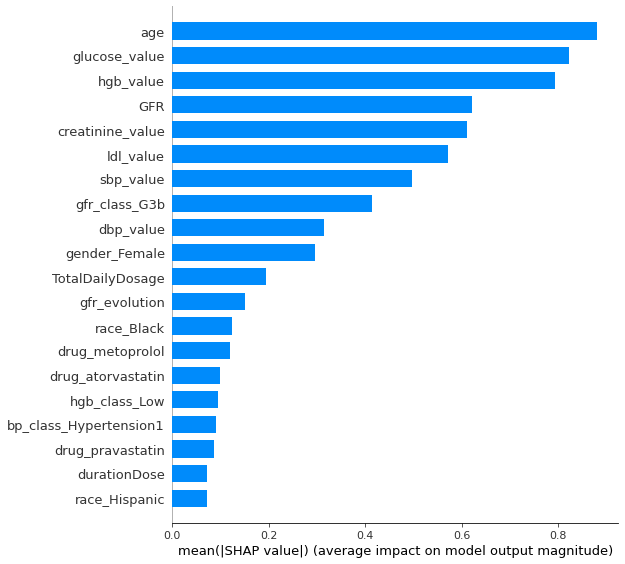

In [38]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type = "bar")

In [41]:
shap_obj = explainer(X_train)

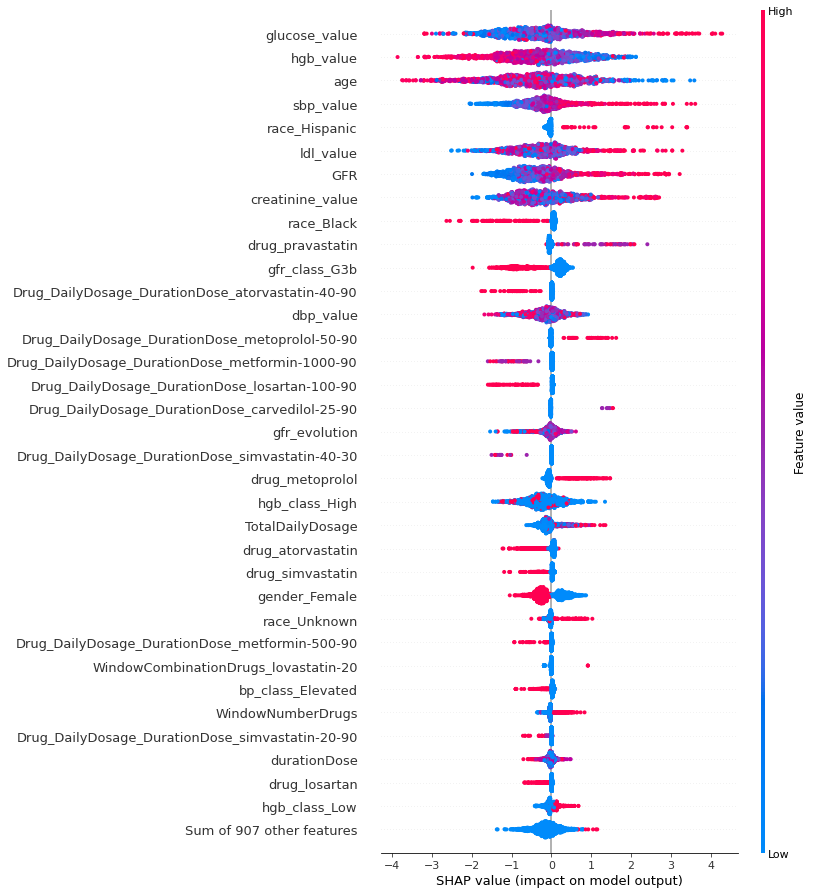

In [45]:
shap.plots.beeswarm(shap_obj, max_display = 35, order = shap_obj.abs.max(0))

In [ ]:
####We will export the shap values and the correlation with the response to visualize them

In [46]:
def ABS_SHAP_df(df_shap,df):
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'pos','neg')
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    return k2

df_shap = ABS_SHAP_df(shap_values,X_train) 

invalid value encountered in true_divide
invalid value encountered in true_divide


In [44]:
df_shap.to_csv("SHAP_ABS_120.csv")

In [ ]:
####We also train other models to compare

In [57]:
from imblearn.ensemble import BalancedBaggingClassifier

In [58]:
brf = BalancedBaggingClassifier(n_estimators = 500, n_jobs=-1, oob_score = True)
brf.fit(X_train, y_train)

BalancedBaggingClassifier(n_estimators=500, n_jobs=-1, oob_score=True)

In [115]:
brf.score(X_train,y_train)

0.999128160418483

In [61]:
y_predOrig = brf.predict(X_test)
print(classification_report(y_test, y_predOrig))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       485
           1       0.88      0.88      0.88       261

    accuracy                           0.92       746
   macro avg       0.91      0.91      0.91       746
weighted avg       0.92      0.92      0.92       746



In [62]:
y_predOrig = brf.predict(X_valid)

print(classification_report(y_valid, y_predOrig))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       365
           1       0.89      0.89      0.89       195

    accuracy                           0.92       560
   macro avg       0.91      0.91      0.91       560
weighted avg       0.92      0.92      0.92       560



In [63]:
##############RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, random_state=0, n_estimators = 500)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=500, random_state=0)

In [64]:
y_predOrig = clf.predict(X_test)

print(classification_report(y_test, y_predOrig))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       485
           1       0.95      0.69      0.80       261

    accuracy                           0.88       746
   macro avg       0.90      0.83      0.85       746
weighted avg       0.89      0.88      0.87       746



In [65]:
y_predOrig = clf.predict(X_valid)


print(classification_report(y_valid, y_predOrig))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       365
           1       0.96      0.69      0.80       195

    accuracy                           0.88       560
   macro avg       0.91      0.84      0.86       560
weighted avg       0.89      0.88      0.88       560



In [67]:
####Logistic Regression
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=0, max_iter = 10000).fit(X_train, y_train)

In [68]:
y_predOrig = lg.predict(X_test)


print(classification_report(y_test, y_predOrig))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       485
           1       0.72      0.53      0.61       261

    accuracy                           0.76       746
   macro avg       0.75      0.71      0.72       746
weighted avg       0.76      0.76      0.75       746

